In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


2025-06-24 10:02:21.549475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750759341.770021      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750759341.834268      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the dataset from folder
Label the data, resize it and reshuffle the data

In [2]:
data_dir='/kaggle/input/musical/music_instruments'
image_size=(224,224)
batch_size=32  # Dataset would be loaded in 32 batch size to save time and memory instead of loading the data 1 by 1

train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,  # seed=42 ensures the split between train and validation is always the same
    image_size=image_size,
    batch_size=batch_size

)

validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=batch_size)

Found 1806 files belonging to 10 classes.
Using 1445 files for training.
Found 1806 files belonging to 10 classes.
Using 361 files for validation.


2025-06-24 10:02:40.840880: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
class_name=train_ds.class_names
print(class_name)

['accordion', 'banjo', 'drum', 'flute', 'guitar', 'harmonica', 'saxophone', 'sitar', 'tabla', 'violin']


# Optimizing the Code


In [4]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # cacheStores the dataset in memory (or disk) after the first epoch.
# Why: So it doesn’t read and preprocess the images again in every epoch — saves time! and prefetch  Allows the model to fetch the next batch while the current one is being processed. and speeds up data preparation
validation_ds=validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Augmentation
Data augmentation creates slightly modified versions of your training images on-the-fly (during training) to:

1. Reduce overfitting.

2. Improve generalization.

3. Make the model more robust to real-world variations

In [5]:
data_augmentation=models.Sequential([  #The Sequential() model expects a list of layers in order to esecute in orderwise
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomZoom(0.1,),
    layers.RandomRotation(0.1)
])

In [6]:
# we use prepare_ds fun to perform augmentation and optimization at one step

AUTOTUNE=tf.data.AUTOTUNE  # Buffer to speed things up

def prepare_ds(ds,augment=False):
    ds=ds.map(lambda x,y:(data_augmentation(x,training=True),y),num_parallel_calls=AUTOTUNE) if augment else ds
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds=prepare_ds(train_ds,augment=True)  # Training set gets augmented because it's meant to learn from variety.
validation_ds=prepare_ds(validation_ds)   # Validation set is left untouched so you can evaluate performance on real data without randomness.


# Custom CNN Model

In [7]:
model=models.Sequential([
    #  Preprocessing Layers
    layers.Rescaling(1./255,input_shape=(224,224,3)),

    #Cov Layers + Max Pooling
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D(),  # Reduces image size by keeping only the most important features.

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(128,activation='relu'), #A fully connected layer with 128 neurons to learn complex patterns.
    layers.Dropout(0.3), # Randomly turns off 30% of neurons during training to prevent overfitting.
    layers.Dense(len(class_name),activation='softmax') # softmax turns raw scores into probabilities for each class.

    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=('sparse_categorical_crossentropy'),optimizer=optimizer,metrics=['accuracy'])

In [9]:
# Bascically checkpoint saves the best model based on accuracy
checkpoint_cb=ModelCheckpoint('best_model.h5',
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max')

# Early stopping stops training early to avoid overfiting
early_stopping_cb=EarlyStopping(patience=5, #patience is a method Waits for 5 epochs without improvement before reducing.
                                restore_best_weights=True,
                                monitor='val_accuracy',
                                mode='min')
# Helps fine-tune the model when it's stuck and not improving.
reduce_lr_cb=ReduceLROnPlateau(patience=3,monitor='val_loss',factor=0.2,min_lr=1e-6)

callbacks=[checkpoint_cb,early_stopping_cb,reduce_lr_cb]

In [10]:
history=model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.0952 - loss: 2.8774 - val_accuracy: 0.2050 - val_loss: 2.1670 - learning_rate: 0.0010
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.2268 - loss: 2.1181 - val_accuracy: 0.3102 - val_loss: 1.9692 - learning_rate: 0.0010
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.3383 - loss: 1.9364 - val_accuracy: 0.3130 - val_loss: 1.8993 - learning_rate: 0.0010
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.3551 - loss: 1.7896 - val_accuracy: 0.3989 - val_loss: 1.6864 - learning_rate: 0.0010
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.4309 - loss: 1.6578 - val_accuracy: 0.4349 - val_loss: 1.6919 - learning_rate: 0.0010
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.4323 - loss: 1.6220 - val_accuracy: 0.4792 - val_loss: 1.5357 - learning_rate: 0.0010


In [11]:
def plot_training_history(history):

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


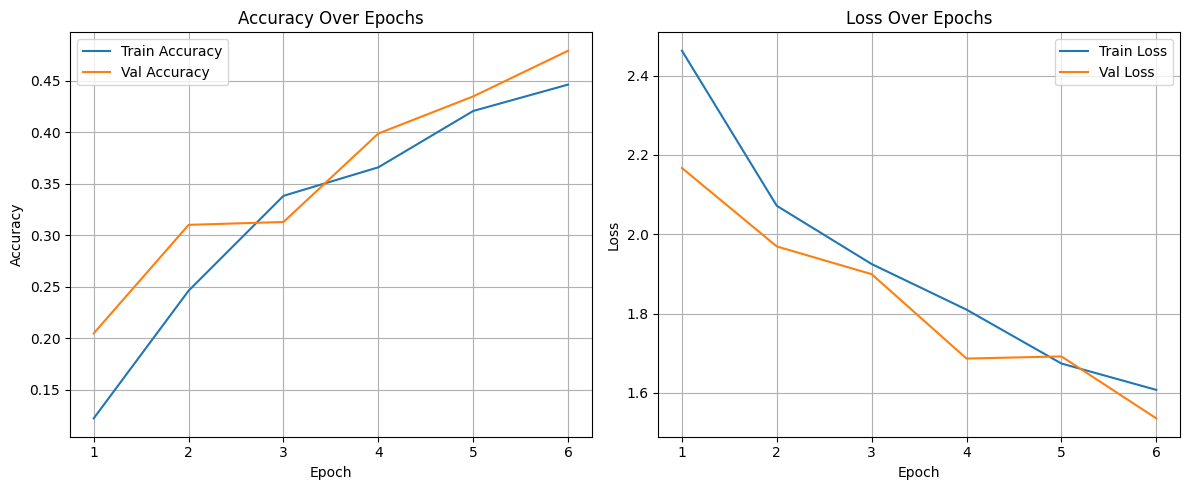

In [12]:
plot_training_history(history)

# MobileNetV2

MobileNetV2 is a lightweight deep learning model designed for image classification and detection, especially optimized for mobile and embedded devices. It’s part of the MobileNet family developed by Google.

1. Lightweight and Fast:
It's designed to run on devices with limited hardware (like smartphones, Raspberry Pi, drones, etc.)

2. Good Accuracy:
Even though it's small, it performs well for many vision tasks like object detection, image classification, face recognition, etc.

3. Transfer Learning Ready:
It’s pre-trained on ImageNet, so you can use it as a feature extractor and fine-tune it for your custom dataset.

In [13]:
mobilenet_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

mobile_model=models.Sequential([
    layers.Rescaling(1./255,input_shape=(224,224,3)),
    mobilenet_base,
    layers.GlobalAveragePooling2D(), #This layer compresses the feature maps (which come out of MobileNet) into a single vector per image.
    layers.Dense(128,activation='relu'),
      layers.Dropout(0.3),  # Randomly “turns off” 50% of neurons during training.
    layers.Dense(len(class_name),activation='softmax')


])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Fine Tuning the MobileNetV2 model

In [14]:
mobilenet_base.trainable=True   # by default all training is freeze bcoz u loaded pretrained model like imagenet, this unfreezes to train and improve accuracy
for layers in mobilenet_base.layers[:100]:
  layers.trainable=False
# Even though you unfreezed all layers above, here you're freezing the first 100 layers again. These early layers detect very general features (like edges, curves, etc.) which are already useful and don’t need re-training.
mobile_model.compile(loss=('sparse_categorical_crossentropy'),# sparse_categorical_crossentropy is used for multi-class classification with integer labels.
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=['accuracy'])


In [15]:
mobile_history = mobile_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3328 - loss: 2.0228 - val_accuracy: 0.7784 - val_loss: 0.7741 - learning_rate: 1.0000e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7705 - loss: 0.7625 - val_accuracy: 0.8504 - val_loss: 0.4973 - learning_rate: 1.0000e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8623 - loss: 0.4640 - val_accuracy: 0.8532 - val_loss: 0.4278 - learning_rate: 1.0000e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9148 - loss: 0.3111 - val_accuracy: 0.8670 - val_loss: 0.4197 - learning_rate: 1.0000e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9532 - loss: 0.1923 - val_accuracy: 0.8864 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9592 - loss: 0.1513 - val_accuracy: 0.8837 - val_loss: 0.3698 - learning_rate: 1.0000e-04


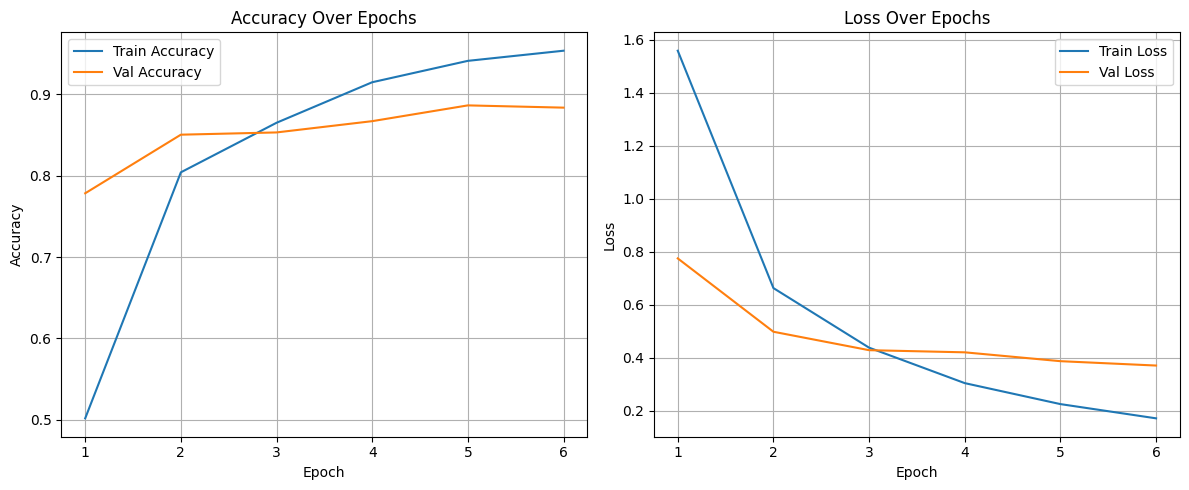

In [16]:
plot_training_history(mobile_history)

# EfficientNetB7
EfficentNetB7 is one of the most powerful models in the EfficientNet family — a set of deep learning architectures developed by Google AI for image classification, detection, and other vision tasks.

Note- Accurate results are higher as compared to MobileNetv2 and size is large not lightweight therefore its slow too

✅ 1. High Accuracy
Among the most accurate image classification models.

Performs better than many larger and deeper models (like ResNet152) with fewer parameters.

✅ 2. Efficient
Despite being large (especially B7), it's still more efficient than other models with similar accuracy.

✅ 3. Great for Transfer Learning
Pre-trained on ImageNet, and fine-tuning it on custom data works very well.

✅ 4. Used in Detection, Segmentation, etc.
Can be used as a backbone for object detection (with models like EfficientDet), image segmentation, and more.

In [17]:

from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

# Make sure class_names is a list of your categories
# class_names = ['guitar', 'flute', 'piano', ...]

# Load the EfficientNetB7 base model without the top layer
efficient_b7_base = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Build the model
efficient_b7_model = models.Sequential([
    layers.Lambda(preprocess_input, input_shape=(224, 224, 3)),  # Preprocess input
    efficient_b7_base,                                            # Base model
    layers.BatchNormalization(),                                  # Normalize features
    layers.GlobalAveragePooling2D(),                              # Flatten to vector
    layers.Dense(128, activation='relu'),                         # Fully connected layer
    layers.Dropout(0.3),                                          # Prevent overfitting
    layers.Dense(len(class_name), activation='softmax')          # Output layer
])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
efficient_b7_base.trainable=True



# compile sets the rules of what to learn
efficient_b7_model.compile(
    loss=('sparse_categorical_crossentropy'), #
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # adam optimizer is used to learn quickly and effiecently and 0001 is that model will learn slowly and effiecntly
    metrics=['accuracy']
)

In [19]:
efficient_b7_base_history=efficient_b7_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2421s 47s/step - accuracy: 0.3296 - loss: 1.9953 - val_accuracy: 0.8670 - val_loss: 1.1951 - learning_rate: 1.0000e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2165s 47s/step - accuracy: 0.8639 - loss: 0.6397 - val_accuracy: 0.9280 - val_loss: 0.4584 - learning_rate: 1.0000e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2075s 45s/step - accuracy: 0.9380 - loss: 0.2550 - val_accuracy: 0.9363 - val_loss: 0.2812 - learning_rate: 1.0000e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2048s 45s/step - accuracy: 0.9774 - loss: 0.1221 - val_accuracy: 0.9446 - val_loss: 0.2414 - learning_rate: 1.0000e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2050s 45s/step - accuracy: 0.9794 - loss: 0.0782 - val_accuracy: 0.9391 - val_loss: 0.2284 - learning_rate: 1.0000e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2024s 44s/step - accuracy: 0.9886 - loss: 0.0655 - val_accuracy: 0.9363 - val_loss: 0.2201 - learning_rate: 1.0000e-04


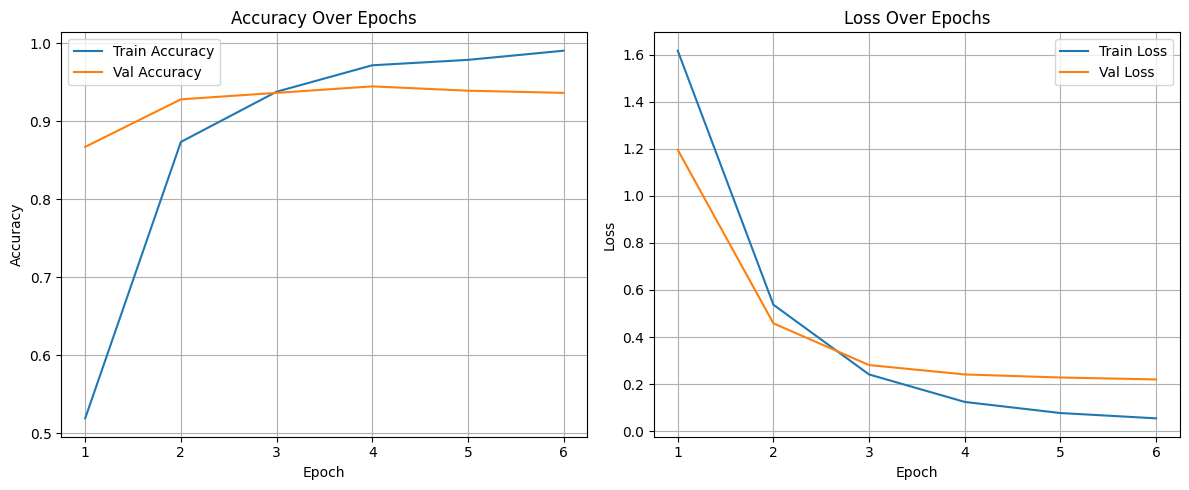

In [20]:
plot_training_history(efficient_b7_base_history)

# Evaluating the model

In [21]:
def evaluate_model(model,dataset, class_name=None):
  y_test=[]
  y_pred=[]

  for batch_images, batch_labels in dataset:
    preds=model.predict(batch_images)
    y_test.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds,axis=-1))

  y_true=np.array(y_true)
  y_pred=np.array(y_pred)

  f1=f1_score(y_test,y_pred,average='weighted')
  precision=precision_score(y_test,y_pred,average='weighted')
  recall=recall_score(y_test,y_pred,average='weighted')
  print("\n📊 Classification Report:\n")
  print(classification_report(y_true, y_pred, target_names=class_name if class_name else None))

  return {
        "f1_score": f1,
        "precision": precision,
        "recall": recall
    }


In [22]:
mobilenet_result = evaluate_model(mobile_model, validation_ds, class_name=class_name)
print(mobilenet_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


UnboundLocalError: cannot access local variable 'y_true' where it is not associated with a value

In [ ]:
efficient_b7_result = evaluate_model(efficient_b7_model, validation_ds, class_name=class_name)
print(efficient_b7_result)